# Image Prediction
We want to be able to perform predictions on arbitrary image sizes, but the network has specifically been trained to process 512x512 images. Passing larger images takes up a lot of memory, so I thought that one way to get around that would be to chop up the image into 512x512 pieces, after which each piece is passed through the network and merged together afterwards. The end result is a method that works on arbitrary image sizes. This notebook is primarily for testing that this functionality works as intended.

In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle


# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

import fig_utils as u
from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator, ImageChunker
import scipy.io
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Load face images

In [2]:
# load original data
data_root_path = "tf_autozoom_2d_randVec20"
data_path = os.path.join("..", data_root_path, "all_test_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
df_test = d["df"]
true_test_x = d["true_x"]
true_test_y = d["true_y"]
adv_test_x = d["adv_x"]
diff_test_x = adv_test_x - true_test_x
orig_pred_test = d["orig_pred"]
adv_pred_test = d["adv_pred"]


# load corrupted data and region
with open(os.path.join("..", "corrupt_img", "test_corrupt_img.pkl"), "rb") as f:
    corrupted_test_x = pickle.load(f)
with open(os.path.join("..", "corrupt_img", "test_corrupt_region.pkl"), "rb") as f:
    corrupted_test_region = pickle.load(f)
with open(os.path.join("..", "corrupt_img", "test_rec_img.pkl"), "rb") as f:
    rec_test_x = pickle.load(f)

# Model Loading
We'll load the model trained on ImageNet

In [3]:
from libs.pconv_model import PConvUnet
model = PConvUnet(vgg_weights=None, inference_only=True)
# model.load(r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase2\weights.26-1.07.h5", train_bn=False)
model.load(os.path.join("data", "logs", "pconv_imagenet.26-1.07.h5"), train_bn=False)

# Face inpainting function

In [4]:
def prep_data(img):
    result = np.dstack((img, img, img))
    result = np.expand_dims(result, 0)
    return result
def img_rescale(img, target_dim):
    return np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((target_dim, target_dim)))/255

def get_inpaint(target_id):
    orig_img = true_test_x[:, target_id].reshape([32, 32]).T
    corrupted_region = corrupted_test_region[target_id]
    m = np.ones([32, 32], dtype=np.int32)
    for (i, j) in corrupted_region:
        m[j, i] = 0
    rescale_img = img_rescale(orig_img, 512)
    rescale_mask = img_rescale(m, 512)
    rescale_img[rescale_mask==0] = 1

    rescale_img = prep_data(rescale_img)
    rescale_mask = prep_data(rescale_mask)
    pred_imgs = model.predict([rescale_img, rescale_mask])
    pred_imgs = np.mean(pred_imgs[0, :, :, :], 2)
    
    return img_rescale(pred_imgs, 32)

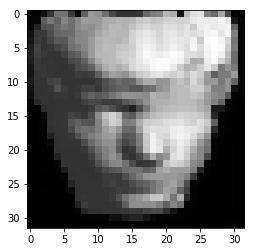

In [5]:
result = get_inpaint(6)
plt.imshow(result, cmap="gray")

# Face inpainting batch

In [6]:
nvInpaint_test_x = np.zeros([1024, 100])
print("Inpainting:")
for img_id in range(100):
    print("{}".format(img_id), end=" ")
    inpaint_x = get_inpaint(img_id)
    nvInpaint_test_x[:, img_id] = inpaint_x.T.reshape([1024])

Inpainting:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [7]:
scipy.io.savemat(os.path.join("..", "test_inpainting", "NV_inpaint_result", "NV_result_all.mat"),
                 {"x_inpaint": nvInpaint_test_x})